# **PHASE 0 DATA PREPARATION AND SPLIT OF THE DATASET**
For this project I will be using the *ADS-B Message Injection Attacks Dataset* from *Mendeley Data*

## Import and Upload

In [491]:
import pandas as pd 
from sklearn.model_selection import train_test_split
#upload the dataset
df = pd.read_csv("Dataset ADB-S.csv")
#see if everything seems ok and take a look of the structure of the dataset
print(f"Uploaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
display(df.head())

Uploaded dataset with 22316 rows and 18 columns


,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,spi,squawk,baroaltitude,geoaltitude,lastposupdate,lastcontact,rss,doppler,label
0,1627918130,0c20b6,41.073349,-73.930298,194.919295,231.859760,0.0,CMP312,False,False,1364.0,10363.2,10675.62,1627918130,1627918130,-85.607674,588.045536,0
1,1627918140,0c20b6,41.062500,-73.948425,194.833737,231.647341,0.0,CMP312,False,False,1364.0,10363.2,10675.62,1627918140,1627918140,-85.601463,827.517243,0
2,1627918150,0c20b6,41.051393,-73.966952,195.153367,231.528897,0.0,CMP312,False,False,1364.0,10363.2,10675.62,1627918150,1627918150,-85.609035,774.034419,0
3,1627918160,0c20b6,41.040918,-73.984368,195.153367,231.528897,0.0,CMP312,False,False,1364.0,10363.2,10675.62,1627918160,1627918160,-85.631899,790.374778,0
4,1627918170,0c20b6,41.035418,-74.006463,195.237429,251.741020,0.0,CMP312,False,False,1364.0,10363.2,10675.62,1627918169,1627918170,-85.744771,-94.629770,1


## SPLIT

60% Train, 20% Val, 20% Test

By making this split, we ensure that we have a dataset to train the data (train), another one to adjust the hiperparameters of the model (val) and by last one to try the accuracy of the model predictions (test)

The variable **icao24** represents the "id" of the aircraft. The same icao24 (aircraft) can have multiple registers at different times. Splitting by this variable ensures us that the model is not learning the ids but the behavior. Each aircraft is in just one dataframe (train, test or val)

In [492]:
aircrafts = df['icao24'].unique()
#60% train_ids, 40% rest_ids -> 20% val_ids, 20% test_ids
train_ids, rest_ids = train_test_split(aircrafts, test_size=0.4, random_state=42)
val_ids, test_ids = train_test_split(rest_ids, test_size=0.5, random_state=42)
#create the dataframes
df_train = df[df['icao24'].isin(train_ids)].copy()
df_val = df[df['icao24'].isin(val_ids)].copy()
df_test = df[df['icao24'].isin(test_ids)].copy()

print(f"Number of rows of each dataframe: Train ({len(df_train)}), Val ({len(df_val)}), Test ({len(df_test)})")

Number of rows of each dataframe: Train (13778), Val (4334), Test (4204)


## Order the train dataframe by time

We only order this dataframe because is the one we are working with, the other two will be only used for testing and adjusting.
Ordering each aircraft by time let us have its real trayectory step by step

In [493]:
df_train = df_train.sort_values(by=['icao24', 'time']).reset_index(drop=True)
#reorder and crate a new index

# **PHASE 1 STUDYING THE VARIABLES** 

import the packages and libraries

In [494]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

## Class Definition
- **Label 0: NORMAL** - Legitimate traffic
- **Label 1: PATH MODIFICATION** - Altered trajectory coordinates (lat/lon) of a real aircraft
- **Label 2: GHOST INJECTION** - Non-existent aircraft with artificial flight patterns
- **Label 3: VELOCITY DRIFT** - The reported speed doesn't match with the real movement of the aircraft

In [495]:
print("\nClasees distribution:")
print("\nNumber of cases of each class")
print(df_train['label'].value_counts())
print("\nPercentage of each class")
print(df_train['label'].value_counts(normalize=True) * 100)


Clasees distribution:

Number of cases of each class
label
0    6722
2    3977
1    1544
3    1535
Name: count, dtype: int64

Percentage of each class
label
0    48.787923
2    28.864857
1    11.206271
3    11.140949
Name: proportion, dtype: float64


## Airplane balance

Here we see for each aircraft how many times has been registed with the different labels. For example, an aircraft that had real trayectories but was hacked will have both, labels 0 and 1,2 or 3. 

In [496]:
aircraft_label = pd.crosstab(df_train['icao24'], df_train['label'])
display(aircraft_label.head(20)) #Only print the 20 first rows to see how it works

label,0,1,2,3
icao24,,,,
0c20b6,4,13,0,5
20102c,0,0,267,0
3ec212,0,0,60,0
4079eb,1,7,0,5
43c7d8,0,0,267,0
48497b,0,0,267,0
4ba94f,26,82,0,29
7103d8,16,36,0,8
71c359,24,67,0,21


## Average trayectory duration

Calculate for each aircraft and label what is the duration (in seconds) of the trayectory.
Then, for each label calculate the average duration.


In [497]:
df = df_train.sort_values(['icao24', 'time'])

df['new_flight'] = (
    (df['onground'].shift(1) == True) & (df['onground'] == False)
) | (
    df['time'].diff() > 600  #10 min because messages are sent each 0.5 / 1 sec
) | (
    df['icao24'] != df['icao24'].shift(1)
)

df['flight_id'] = df.groupby('icao24')['new_flight'].cumsum()

durations = df.groupby(['icao24', 'flight_id', 'label'])['time'].agg(lambda x: x.max() - x.min())
avg_duration = durations.groupby('label').mean()
print(avg_duration)


label
0     453.902439
1     371.428571
2    2658.125000
3     322.666667
Name: time, dtype: float64


## Flight Duration Analysis

The calculated duration represents the Time-on-Target (ToT). This is the total time the aircraft is in the receiver's coverage area (antenna detection range).
Analyzing the average duration of the flights reveals different behaviors:

- **Label 0: NORMAL (Avg 454s/7.5m)** Represents the standard time a real aircraft takes to cross the receiver's coverage area

- **Label 1: PATH MODIFICATION (Avg 371s/6.2m)** Since this attack modifies the coordinates of a real flight, its duration is limited to the physical presence of the victim aircraft

- **Label 2: GHOST (Avg 2658s/44.3m)** Here we can see that the average time is greater than on the other cases, what indicates the attacker's intention of maximizing the damage. Ghost aircraft are often programmed to loop or hover within the radar range to saturate the system

- **Label 3: VELOCITY DRIFT (Avg 323s/5.4m)** Similar to Label 1, this attack just modifies live signals



## Descriptive statistics

Study of the velocity and baroaltitude of each label

In [498]:
stats = df_train.groupby('label')[['velocity', 'baroaltitude']].describe().T
display(stats)

label                          0             1            2             3
velocity     count   5193.000000   1377.000000  3977.000000   1340.000000
             mean      91.132773     93.353719   148.960635    142.450560
             std       61.618453     66.862356    86.994315     76.616286
             min        0.000000      1.626815     1.002808      0.000000
             25%       48.622443     48.374152    72.878713     82.830277
             50%       70.582017     68.469385   148.092640    138.181612
             75%      131.643395    130.190928   224.700553    201.786677
             max      311.837095    287.447167   299.955020    299.616708
baroaltitude count   5171.000000   1300.000000  3977.000000   1303.000000
             mean    1617.816921   1748.584846   282.877699   1773.629563
             std     2594.097251   2774.938821  1883.382259   2944.008146
             min      -60.960000    -15.240000 -2950.733065    -22.860000
             25%      129.540000    121.920000 -1432.839435     60.960000
             50%      487.680000    601.980000   -38.392715    320.040000
             75%     1668.780000   1813.560000  1990.382354   1581.150000
             max    14074.140000  11155.680000  3647.561152  11285.220000

## Interpretation of flight parameters

- **Label 0: NORMAL**
    - **Velocity:** Shows a normal distribution typical for aircraft in different phases of flight
    - **Altitude:** Normal for flights with cruise segments

- **Label 1: PATH MODIFICATION**
    - **Velocity & Altitude:** Very similar to label 0
    - **Interpretation:** As only changes trajectory coordinates velocity and altitude doesn't show extrange values

- **Label 2: GHOST INJECTION**
    - **Velocity:** Shows a much higher average than the real aircrafts, this suggests ghost aircraffts are often injected with high and constant speeds
    - **Altitude:** The mean is very low and the median is *negative*. Also, the minimum value is *-2950m (imposible)*
    - **Interpretation:** Clear indicator of non-real data. The attacker injected "Ghost" aircraft with altitudes that are physically impossible, what doen't represent realistic flights

- **Label 3: VELOCITY DRIFT**
    - **Velocity:** High average speed 
    - **Interpretation:** In this attack, the reported velocity is intentionally altered. The model can detect taht the reported speed and the actual movement in coordinates doesn't match, becoming easily detectable
    - **Altitude:** Realistic and normal

## Null values

In [499]:
def nulls(df):
    nulls = df.isnull().sum()
    perc = (nulls / len(df)) * 100
    return pd.DataFrame({'nulls': nulls, 'percent': perc})
nulls(df_train)

,nulls,percent
time,0,0.000000
icao24,0,0.000000
lat,435,3.157207
lon,435,3.157207
velocity,1891,13.724779
heading,1891,13.724779
vertrate,1891,13.724779
callsign,139,1.008855
onground,0,0.000000
spi,0,0.000000


# Detection  of no informative variables

We look for the percentage of the most frecuent value dor each column, if the most dominant value appears more than the 99% of the times we can say that is irrelevant and then delete that variable

In [500]:
non_informative = (
    df_train.apply(lambda col: col.value_counts(normalize=True).iloc[0])
    .sort_values(ascending=False)
)

print("Percentage of the dominant value in each variable:")
print(non_informative)

to_drop = non_informative[non_informative > 0.99].index.tolist()

print("\nNon informative variables:")
print(to_drop)


cols_to_drop = to_drop

df_train = df_train.drop(columns=cols_to_drop)
df_val = df_val.drop(columns=cols_to_drop)
df_test = df_test.drop(columns=cols_to_drop)
print(f"\nColumns dropped, restant columns: {df_train.columns.tolist()}")

Percentage of the dominant value in each variable:
spi              0.999927
onground         0.755843
label            0.487879
squawk           0.146946
vertrate         0.110036
doppler          0.062299
baroaltitude     0.030891
callsign         0.019796
icao24           0.019596
rss              0.017837
velocity         0.015647
heading          0.014133
geoaltitude      0.011747
lon              0.009518
lat              0.005546
lastposupdate    0.005371
lastcontact      0.004355
time             0.004210
dtype: float64

Non informative variables:
['spi']

Columns dropped, restant columns: ['time', 'icao24', 'lat', 'lon', 'velocity', 'heading', 'vertrate', 'callsign', 'onground', 'squawk', 'baroaltitude', 'geoaltitude', 'lastposupdate', 'lastcontact', 'rss', 'doppler', 'label']


# **PHASE 2 UNIVARIANTE ANALYISIS** 

## Density histograms for speed and altitude

Thanks to these histograms, we'll be able to identify anomalies in a visual and easy way

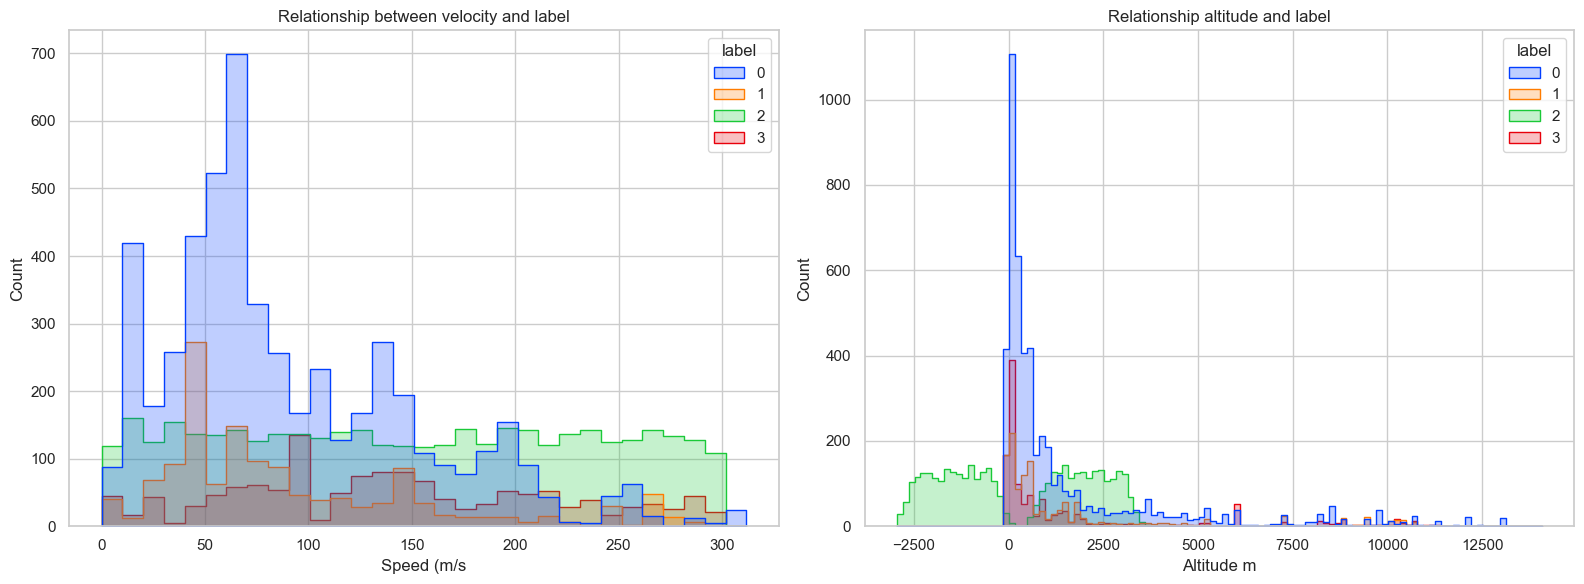

In [501]:
#Set the style for the visuals
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 6))

#Velocity
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='velocity', hue='label', element='step', palette='bright', common_norm=False)
plt.title('Relationship between velocity and label')
plt.xlabel('Speed (m/s')

#Altitude
plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='baroaltitude', hue='label', element='step', palette='bright', common_norm=False)
plt.title('Relationship altitude and label')
plt.xlabel('Altitude m')

plt.tight_layout()
plt.show()

### Interpretation
**Velocity:** 
- Label 0: normal speed
- Label 1: normal speed (similar to the distribution of label 0)
- Label 2: dispersed and uniform
- Label 3: inconsistent values

**Altitude:**
- Label 0: a lot of values near 0 (aircrafts on land)
- Label 1: similar to normal (label 0)
- Label 2: a lot of dispersion between values, including negative values *(imposible)*
- Label 3: looks similar to label 0

We can see the following anomalies:

- Label 2 and 3 have strange speeds compared with normal (real) flights. Gosth fligths have a uniform distribution because they are synthetically generated using constant or linear mathematical parameters, while in the velocity drift attacks the speed is inconsistent because he attacker is intentionally injecting a mismatch between the reported velocity vector and the actual displacement of the coordinates over time.

- Label 2 shows a lot of dispersion between altitude values, including negative ones (what is imposible), that is because this flights could be generated by software without the neccesary constraints

## Boxplots

For velocity, altitude and vertrate (vertical rate, speed of ascending or descending)

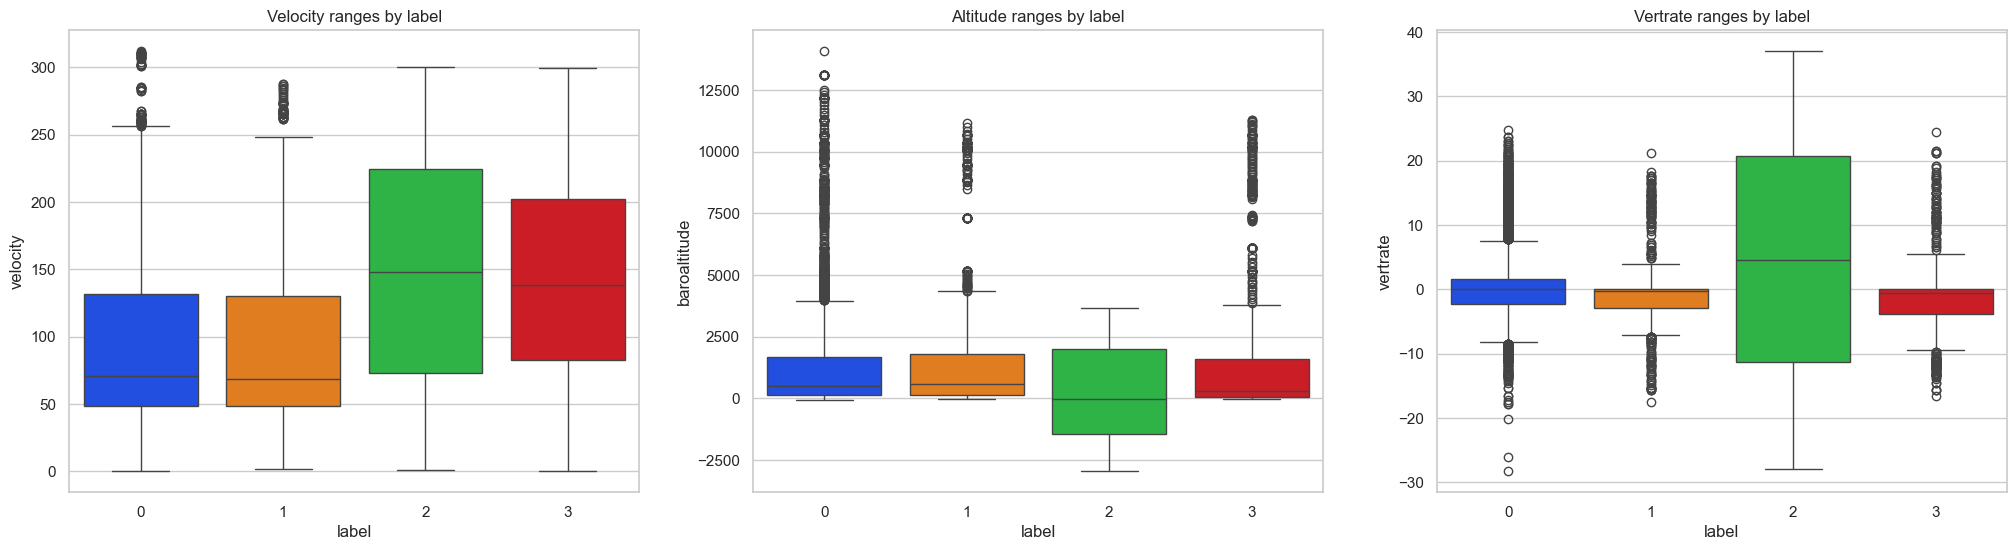

In [502]:
plt.figure(figsize=(25, 6))

# 1 Subplot: Velocity
plt.subplot(1, 3, 1)
sns.boxplot(data=df_train, x='label', y='velocity', hue = 'label', palette='bright', legend = False)
plt.title('Velocity ranges by label')

#2 subplot altitude 
plt.subplot(1, 3, 2)
sns.boxplot(data=df_train, x='label', y='baroaltitude', hue = 'label', palette='bright', legend = False)
plt.title('Altitude ranges by label')

#3 subplot vertrate
plt.subplot(1, 3, 3)
sns.boxplot(data=df_train, x='label', y='vertrate', hue = 'label', palette='bright', legend = False)
plt.title('Vertrate ranges by label')

plt.show()

**velocity:**
- Label 0: realistic, a lor of velocities of the taxi, inicial ascension and aproximation phases
- Label 1: realistic
- Label 2: higher velocities (cruise phase), a lot of dispersion but normal
- Label 3: a lot of dispersion too

**Altitude:**
- Label 0: normal, great quantity of aircrafts on land
- Label 1: very similar to label 0
- Label 2: a lot of dispersion and negative (imposible) values
- Label 3: similar to label 0

**Vertrate:**
Here, it can be seen that in the label 2 there is a lot of variability with extreme values (positive and negative) what occurs because the attacker modifies the altitude

# **PHASE 3 BIVARIATE ANALYSIS**

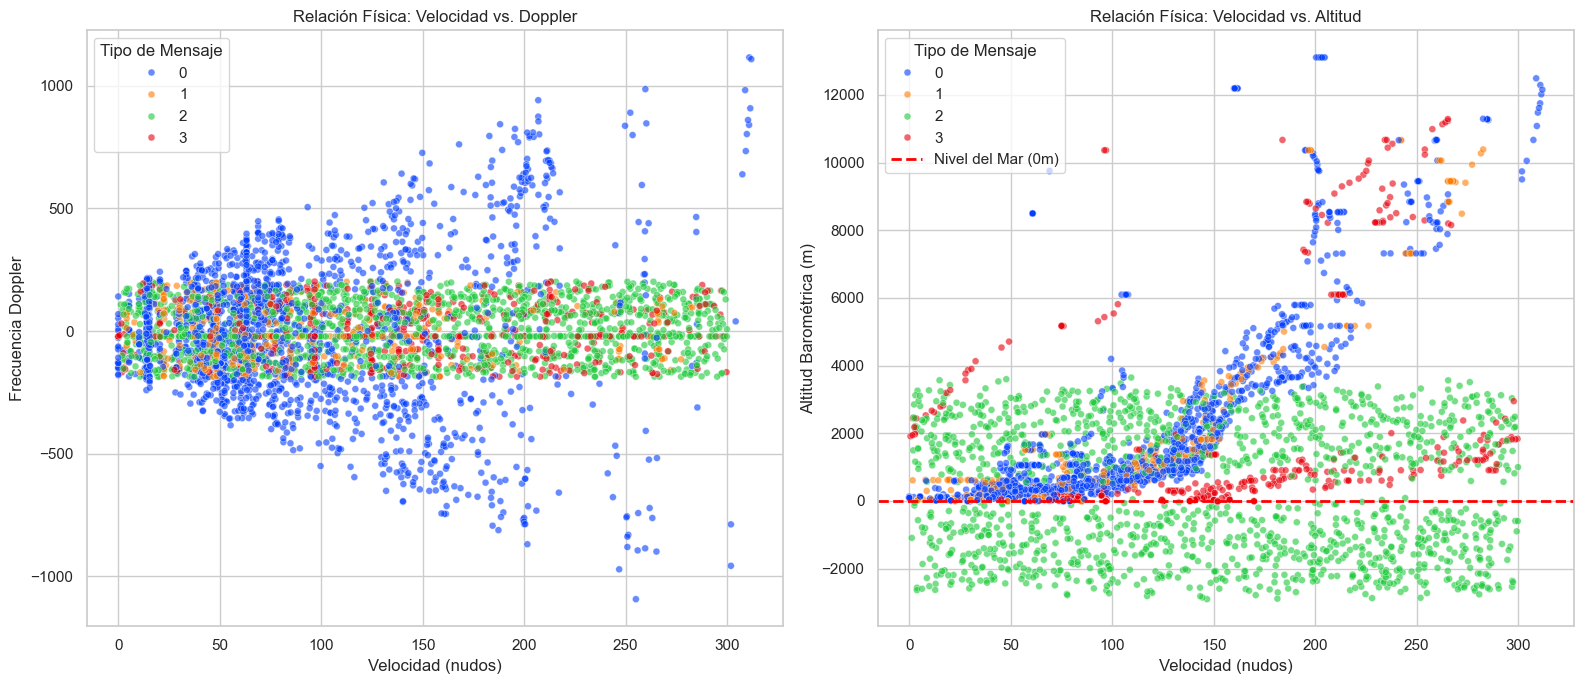

In [503]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual
sns.set_theme(style="whitegrid")

# Tomamos una muestra aleatoria de 5000 puntos para que la gráfica sea legible y rápida
# Si usáramos todos los puntos, sería una mancha ilegible.
df_sample = df_train.sample(n=5000, random_state=42)

plt.figure(figsize=(16, 7))

# --- GRÁFICO 1: LA FIRMA DE RADIOFRECUENCIA (Velocity vs Doppler) ---
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=df_sample, 
    x='velocity', 
    y='doppler', 
    hue='label', 
    palette='bright', 
    alpha=0.6, 
    s=25
)
plt.title('Relación Física: Velocidad vs. Doppler')
plt.xlabel('Velocidad (nudos)')
plt.ylabel('Frecuencia Doppler')
plt.legend(title='Tipo de Mensaje')

# --- GRÁFICO 2: EL PERFIL DE VUELO (Velocity vs Baroaltitude) ---
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df_sample, 
    x='velocity', 
    y='baroaltitude', 
    hue='label', 
    palette='bright', 
    alpha=0.6,
    s=25
)
# Línea roja para marcar el nivel del mar (0 metros)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Nivel del Mar (0m)')
plt.title('Relación Física: Velocidad vs. Altitud')
plt.xlabel('Velocidad (nudos)')
plt.ylabel('Altitud Barométrica (m)')
plt.legend(title='Tipo de Mensaje')

plt.tight_layout()
plt.show()

interpretacion


FASE 4


In [504]:
# ==========================================
# FASE 4: CREACIÓN DE VARIABLES FÍSICAS
# ==========================================
import numpy as np

# 1. ORDENAR DATOS
# Vital: Para calcular diferencias entre mensajes, deben estar ordenados cronológicamente por avión.
df_train = df_train.sort_values(by=['icao24', 'time'])

print("Generando variables físicas...")

# 2. CÁLCULO DE DIFERENCIALES (Deltas)
# Agrupamos por avión para no mezclar datos de vuelos distintos

# Delta Tiempo (dt): Tiempo pasado desde el último mensaje
df_train['dt'] = df_train.groupby('icao24')['time'].diff().fillna(10) # Asumimos 10s para el primer mensaje

# Delta Velocidad y Aceleración
df_train['d_vel'] = df_train.groupby('icao24')['velocity'].diff().fillna(0)
# Evitamos división por cero: si dt=0, ponemos un valor mínimo (0.1s)
df_train['acceleration'] = df_train['d_vel'] / df_train['dt'].replace(0, 0.1)

# Delta Rumbo (Turn Rate)
df_train['d_heading'] = df_train.groupby('icao24')['heading'].diff().fillna(0)
# Corregimos el salto de 359° a 1° (no es un giro de -358°, es de +2°)
df_train['d_heading'] = df_train['d_heading'].apply(lambda x: x if abs(x) <= 180 else 360 - abs(x))
df_train['turn_rate'] = df_train['d_heading'] / df_train['dt'].replace(0, 0.1)

# Delta Altitud (Climb Rate calculado)
df_train['d_alt'] = df_train.groupby('icao24')['baroaltitude'].diff().fillna(0)
df_train['climb_rate_calc'] = df_train['d_alt'] / df_train['dt'].replace(0, 0.1)

# 3. DETECCIÓN DE "TELETRANSPORTE" (Distancia recorrida)
# Usamos una aproximación Euclidiana simple (suficiente para anomalías grandes)
df_train['d_lat'] = df_train.groupby('icao24')['lat'].diff().fillna(0)
df_train['d_lon'] = df_train.groupby('icao24')['lon'].diff().fillna(0)
df_train['distance_jump'] = np.sqrt(df_train['d_lat']**2 + df_train['d_lon']**2)

# 4. ROLLING STATISTICS (La clave para el Ghosting/Path Mod)
# Calculamos la desviación estándar en ventanas de 3 mensajes.
# - Avión Real: Pequeña variación (viento, sensores).
# - Ataque: A menudo 0 absoluto (artificial) o enorme (ruido).
window_size = 3
cols_rolling = ['velocity', 'heading', 'baroaltitude', 'rss']

for col in cols_rolling:
    # Calculamos la desviación estándar (std)
    df_train[f'{col}_std'] = df_train.groupby('icao24')[col].rolling(window_size).std().reset_index(0, drop=True).fillna(0)

print("Variables generadas exitosamente:")
print(f"- Física: acceleration, turn_rate, climb_rate_calc")
print(f"- Espacial: distance_jump")
print(f"- Estadísticas: {cols_rolling} (+_std)")

Generando variables físicas...
Variables generadas exitosamente:
- Física: acceleration, turn_rate, climb_rate_calc
- Espacial: distance_jump
- Estadísticas: ['velocity', 'heading', 'baroaltitude', 'rss'] (+_std)


C:\Users\sofia\AppData\Local\Temp\ipykernel_26272\795729127.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x='label', y='acceleration', showfliers=False, palette='bright')
C:\Users\sofia\AppData\Local\Temp\ipykernel_26272\795729127.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train, x='label', y='velocity_std', showfliers=False, palette='bright')


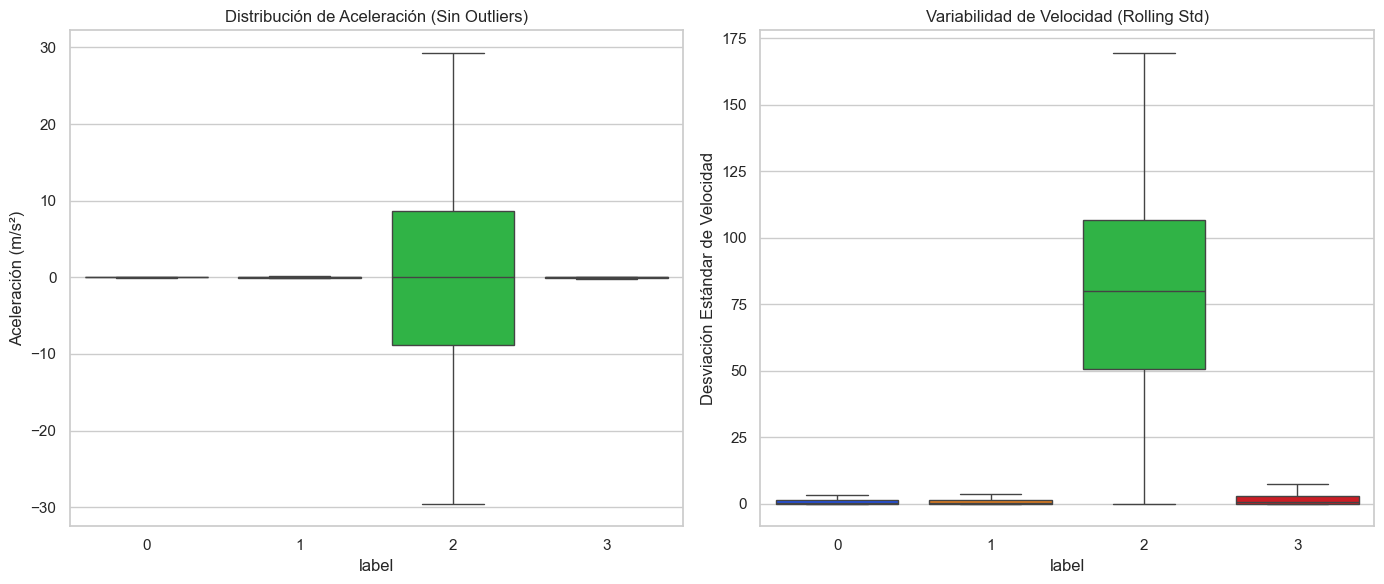

In [505]:
# Verificamos visualmente si las nuevas variables ayudan a separar
plt.figure(figsize=(14, 6))

# Gráfico 1: Aceleración (Detecta maniobras imposibles)
plt.subplot(1, 2, 1)
# Hacemos zoom en el rango -10 a 10 para ver detalles, ignorando outliers extremos
sns.boxplot(data=df_train, x='label', y='acceleration', showfliers=False, palette='bright')
plt.title('Distribución de Aceleración (Sin Outliers)')
plt.ylabel('Aceleración (m/s²)')

# Gráfico 2: Estabilidad de Velocidad (std)
plt.subplot(1, 2, 2)
sns.boxplot(data=df_train, x='label', y='velocity_std', showfliers=False, palette='bright')
plt.title('Variabilidad de Velocidad (Rolling Std)')
plt.ylabel('Desviación Estándar de Velocidad')

plt.tight_layout()
plt.show()


--- Aplicando ingeniería física ---

--- Cross Validation + Grid Search ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Mejor F1 CV: 0.9809207230355635

--- Optimizando threshold en VALIDACIÓN ---
Threshold óptimo: 0.56
F1 en validación con threshold óptimo: 0.9003

--- EVALUACIÓN FINAL EN TEST ---
              precision    recall  f1-score   support

    Legítimo       0.85      0.97      0.91      1600
      Ataque       0.96      0.82      0.89      1490

    accuracy                           0.90      3090
   macro avg       0.91      0.89      0.90      3090
weighted avg       0.91      0.90      0.90      3090

Accuracy: 0.897411003236246


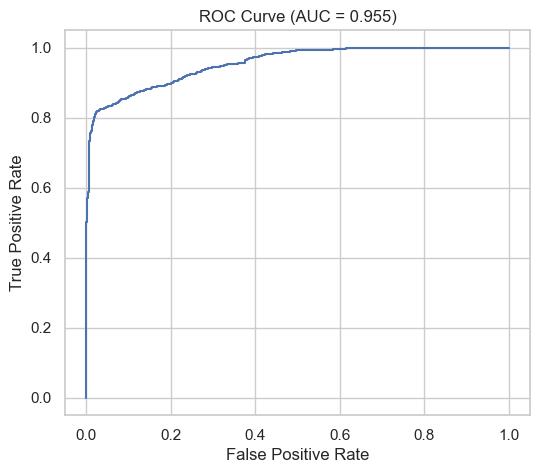

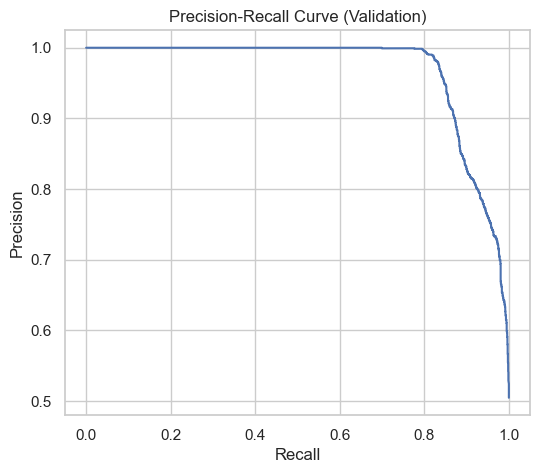

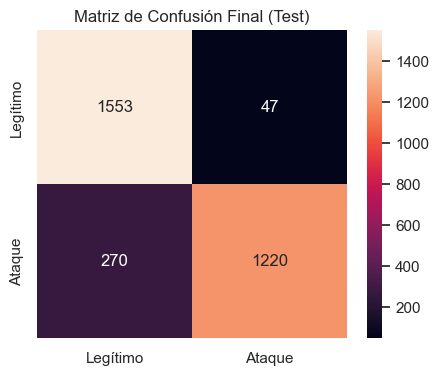

In [506]:
# ==============================================================================
# FASE FINAL TFG: RANDOM FOREST ROBUSTO CON CV + THRESHOLD OPTIMIZATION
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_recall_curve,
    roc_curve,
    auc
)

sns.set_theme(style="whitegrid")

# ==============================================================================
# 1. FUNCIÓN DE INGENIERÍA FÍSICA (APLICABLE A CUALQUIER DATASET)
# ==============================================================================

def generar_variables_fisicas(df_input):

    df = df_input.copy()
    df = df.sort_values(by=['icao24', 'time'])

    # Delta tiempo
    df['dt'] = df.groupby('icao24')['time'].diff().fillna(10)

    # Aceleración
    df['d_vel'] = df.groupby('icao24')['velocity'].diff().fillna(0)
    df['acceleration'] = df['d_vel'] / df['dt'].replace(0, 0.1)

    # Giro
    df['d_heading'] = df.groupby('icao24')['heading'].diff().fillna(0)
    df['d_heading'] = df['d_heading'].apply(
        lambda x: x if abs(x) <= 180 else 360 - abs(x)
    )
    df['turn_rate'] = df['d_heading'] / df['dt'].replace(0, 0.1)

    # Climb rate real
    df['d_alt'] = df.groupby('icao24')['baroaltitude'].diff().fillna(0)
    df['climb_rate_calc'] = df['d_alt'] / df['dt'].replace(0, 0.1)

    # Teletransporte
    df['d_lat'] = df.groupby('icao24')['lat'].diff().fillna(0)
    df['d_lon'] = df.groupby('icao24')['lon'].diff().fillna(0)
    df['distance_jump'] = np.sqrt(df['d_lat']**2 + df['d_lon']**2)

    # Rolling stats
    window_size = 3
    cols_rolling = ['velocity', 'heading', 'baroaltitude', 'rss']

    for col in cols_rolling:
        df[f'{col}_std'] = (
            df.groupby('icao24')[col]
            .rolling(window_size)
            .std()
            .reset_index(0, drop=True)
            .fillna(0)
        )

    return df


# ==============================================================================
# 2. APLICAR INGENIERÍA A TRAIN / VAL / TEST
# ==============================================================================

print("\n--- Aplicando ingeniería física ---")

train_proc = generar_variables_fisicas(df_train)
val_proc   = generar_variables_fisicas(df_val)
test_proc  = generar_variables_fisicas(df_test)

features = [
    'velocity', 'heading', 'vertrate', 'baroaltitude', 'rss', 'doppler',
    'acceleration', 'turn_rate', 'climb_rate_calc',
    'velocity_std', 'heading_std', 'baroaltitude_std', 'rss_std',
    'distance_jump'
]

train_proc = train_proc.dropna(subset=features)
val_proc   = val_proc.dropna(subset=features)
test_proc  = test_proc.dropna(subset=features)

def get_binary(df):
    X = df[features]
    y = df['label'].apply(lambda x: 0 if x == 0 else 1)
    return X, y

X_train, y_train = get_binary(train_proc)
X_val, y_val     = get_binary(val_proc)
X_test, y_test   = get_binary(test_proc)

# ==============================================================================
# 3. CROSS VALIDATION + GRID SEARCH (SOLO TRAIN)
# ==============================================================================

print("\n--- Cross Validation + Grid Search ---")

param_grid = {
    'n_estimators': [200],
    'max_depth': [None, 15],
    'min_samples_split': [5, 10],
    'class_weight': ['balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid = GridSearchCV(
    rf,
    param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor F1 CV:", grid.best_score_)

best_model = grid.best_estimator_

# ==============================================================================
# 4. AJUSTE DE THRESHOLD USANDO VALIDACIÓN
# ==============================================================================

print("\n--- Optimizando threshold en VALIDACIÓN ---")

y_val_proba = best_model.predict_proba(X_val)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Threshold óptimo:", round(best_threshold, 3))
print("F1 en validación con threshold óptimo:", round(f1_scores[best_idx], 4))

# ==============================================================================
# 5. EVALUACIÓN FINAL EN TEST
# ==============================================================================

print("\n--- EVALUACIÓN FINAL EN TEST ---")

y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred  = (y_test_proba >= best_threshold).astype(int)

print(classification_report(
    y_test,
    y_test_pred,
    target_names=['Legítimo', 'Ataque']
))

print("Accuracy:", accuracy_score(y_test, y_test_pred))

# ==============================================================================
# 6. CURVAS ROC Y PR
# ==============================================================================

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.title("Precision-Recall Curve (Validation)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# ==============================================================================
# 7. MATRIZ DE CONFUSIÓN FINAL
# ==============================================================================

plt.figure(figsize=(5,4))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Legítimo', 'Ataque'],
            yticklabels=['Legítimo', 'Ataque'])
plt.title("Matriz de Confusión Final (Test)")
plt.show()
